# Final Code

<div class="alert alert-success">
All of the concepts on choosing the subsets and data particularities in this code is concluded from the 'EDA - analysing Nans' notebook, which is also included in this repository. <br> <br>

</div>


# Dataset tuning

All of this steps below are based on the EDA notebook also present in this repository.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Math, Latex
from scipy import stats, linalg
% matplotlib inline


df = pd.read_csv('SPcities2.csv', decimal=',', encoding='Iso-8859-1', sep=';')

## Seting the data as seeing in the EDA notebook ( also in this repository)
df = df[df.year > 2001]
df = df[df.year < 2016]

data = df[df.year == 2013] # like we saw in the EDA on missing values, 2013 should be the best year for our analysis
                           # this was the case because, for this method, we need the year with more information, 
                            # in this case 2013

# cleaning the all null features

data_clean = data
data_clean = data_clean.drop('HDI', 1)
data_clean = data_clean.drop('educ_superior', 1)
data_clean = data_clean.drop('tax_revenue', 1)

------------------------------------------------ END OF DATASET TUNING ----------------------------------------------

The I-Distance method:

<img src='Idistancenorm.png'> </img>

The I-Distance <b>squared</b> method:

<img src='idistance.png'> </img>

<img src='disceffect.png'> </img>

"where di(r, s) is the distance between the values of variable Xi for er and es e.g. the discriminate effect" and <br> <br>

"σi the standard deviation of Xi, and rji.12 … j − 1 is a partial coefficient of the correlation between Xi and Xj, (j < i)"

# Creating the tools to use the method

In [2]:
# this idea for partial correlation was obtained from : https://gist.github.com/fabianp/9396204419c7b638d38f

## Partial Correlation Matrix for the rij variable in the formula

from scipy import stats, linalg

def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """
    
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr

        
    return P_corr

In [3]:
# The reference hyperplane to calculate all the distances from.
# Here we are going to set the city with the smallest value for GDP per capita

data_clean.sort_values('gdp_per', ascending=True).head()

,city,year,gdp_per,gdp_growth,private_inv,pub_inv,export,import,violence,primary_enrolls,...,hosp_rooms,hosp_rooms_per,jobs,jobs_revenue,population,urban_pop,rural_pop,olding,urbing,fundamental
4450,Itapirapuã Paulista,2013,6956.90,0.098176,NaN,917044.27,NaN,NaN,12,102.25,...,NaN,NaN,521.0,1266.38,3954,1959,1995.0,42.32,49.54,64.0
10196,Taquaral,2013,7307.11,-0.110965,NaN,91200.00,NaN,NaN,9,89.24,...,NaN,NaN,500.0,1159.92,2729,2623,106.0,74.68,96.12,34.0
8462,Riversul,2013,7386.98,0.132233,NaN,NaN,NaN,NaN,72,94.24,...,NaN,NaN,533.0,1188.74,6003,4423,1580.0,76.79,73.68,64.0
7816,Pracinha,2013,7650.01,0.210545,NaN,NaN,NaN,NaN,7,99.51,...,NaN,NaN,264.0,1307.56,2864,1372,1492.0,77.06,47.91,17.0
285,Álvaro de Carvalho,2013,7653.97,-0.031318,NaN,1162680.60,NaN,NaN,29,100.62,...,NaN,NaN,359.0,1443.34,4763,3081,1682.0,60.52,64.69,55.0


Here, since the city of Itapirapua Paulista has the smallest value for the features of our most interest, it will be the hyperplane reference for our calculations.

In [4]:
data_values = data_clean.drop('year' ,1).fillna(0) # Base dataset for all calculations


reference = data_values.sort_values('gdp_per', ascending=True).iloc[0:1,:] # Base reference for all calculations

# Building the function to calculate the I-distance squared

Like the steps followed by <a href="http://www.sciencedirect.com/science/article/pii/S0264999314000558">reference article </a> , we should : <br>

<ol>
<li>Calculate the value of the discriminate effect of the variable X1, the most significant variable, that which provides the largest amount of information on the phenomena that is to be ranked; </li>
<li> Add the value of the discriminate effect of X2 which is not covered by X1;</li>
<li> Add the value of the discriminate effect of X3 which is not covered by X1 and X2;</li>
<li> Repeat the procedure for all variables;</li>
<li> Calculte the correlation coefficient of each indicator with the I-distance;</li>
<li> Exclude the smallest non significant coefficient;</li>
<li> Repeat (6) until only significant features remain.</li>


In [5]:
## Creating a function to the calculation to operate 1-4 above: 

def I_distance(data_values, reference):
    
    # getting the correlation matrix done
    data_corr = data_values.drop('city' ,1).fillna(0)
    col_labels = list(data_corr.columns)
    corre = pd.DataFrame(partial_corr(data_corr), columns=col_labels)
                         
    #starting the I-Distance calculation                     
    ncolums = data_corr.shape[1]
    nrows = data_corr.shape[0]
    somatory = []
    i2_index = {'city': [], 'I-Distance': []}
    for r in range(0,nrows):
        somatory = []    
        for i in range(0,ncolums):
            prod = 1
            summ_1 = 0
            summ_1 = ((data_corr.iloc[r,i] - reference.iloc[0,i+1])**2)/np.var(data_corr.iloc[:,i]) #distance squared divided by variance
            for k in range(i+1):
                if corre.iloc[i,k] == 1:
                    prod *= 1
                else:
                    prod *= (1-(corre.iloc[i,k])**2)
            somatory.append(summ_1*prod)
        i2_index['city'].append(data_values.iloc[r,0])
        i2_index['I-Distance'].append(np.cumsum(somatory)[-1])
    

## 5 - 6 selecting sigficant features

# calculating the rank of features and p-values

    distance = pd.DataFrame(i2_index)

    data = data_values.iloc[:,1:]
    feature_rank = {'feature': [], 'r': [], 'p-value': []}

    # creating the rank with correlation, p-values and name of features
    for col, values in data.iteritems():
        feature_rank['feature'].append(col)
        feature_rank['r'].append(stats.pearsonr(values, distance['I-Distance'])[0])
        feature_rank['p-value'].append(stats.pearsonr(values, distance['I-Distance'])[1])
    

    # manipulating the rank to select smallest correlation value with no significant p-value valor (>0.01)
    rank = pd.DataFrame(feature_rank)
    lenght_rank = len(list(rank.columns))
  
    excluded = {'feature' : "" , 'p-value' : 0 }
    for x in range(lenght_rank):
        excluded = {'feature' : "" , 'p-value' : 0 }
        chk = 0
        if rank.sort_values('r').iloc[x,1] >= 0.05 and x <= lenght_rank:  # check if the smallest r value is significant
            excluded['feature'] = rank.sort_values('r').iloc[x,0]
            excluded['p-value'] = rank.sort_values('r').iloc[x,1]
            chk = 1
            break
        elif rank.sort_values('r').iloc[x,1] <= 0.05 and x == lenght_rank:
            chk = 0
            break
        else:
            chk = 0
            continue

    if chk == 1: # returning new data frame if there is some variable to exclude, otherwise is done
        n_values = data_values.drop(excluded['feature'], 1)
        n_ref = reference.drop(excluded['feature'], 1)
        return 'loop',distance,  n_values, n_ref, excluded
    else:
        return 'done', distance, rank, 'ref', excluded # if no features to drop, return distance and rank
        


In [6]:
# 7 - Iterating for the final model until we gett only significant features:

def Final_distance(data_values, reference):
    check, distance, rank, ref, excluded = I_distance(data_values, reference)
    
    cont=1
    while True:
        if check == 'loop':
            print("Iteration of Number: ", cont)
            print("Variable excluded in this iteration:", excluded )
            print("I-Distance rank:")
            print(distance)
            check, distance, rank, ref, excluded = I_distance(rank, ref)
            cont += 1
            continue
        else:
            print("Iterations needed: ", cont-1)
            break
    return check, distance, rank

<h3> The Results for the I-Distance Squared</h3>

In [7]:
check1, distance1, rank1 = Final_distance(data_values, reference)

Iteration of Number:  1
Variable excluded in this iteration: {'feature': 'olding', 'p-value': 0.62152333001401172}
I-Distance rank:
     I-Distance                    city
0     19.574375              Adamantina
1     12.623635                  Adolfo
2      7.619452                   Aguaí
3     14.912675          Águas da Prata
4     10.553639        Águas de Lindóia
5      4.973449  Águas de Santa Bárbara
6    175.278901      Águas de São Pedro
7     14.560906                  Agudos
8      2.860073                Alambari
9     13.647056       Alfredo Marcondes
10     7.707353                  Altair
11     9.946214             Altinópolis
12    16.617030             Alto Alegre
13    55.358300                Alumínio
14    20.329446        Álvares Florence
15     6.563823         Álvares Machado
16     1.786611      Álvaro de Carvalho
17     5.934405             Alvinlândia
18    24.343443               Americana
19    12.963261     Américo Brasiliense
20     8.488222       Améric

In [8]:
rank1.sort_values('r', ascending=False)

,feature,p-value,r
4,violence,0.000000e+00,0.990580
11,jobs,0.000000e+00,0.989353
8,services_add,0.000000e+00,0.985795
6,value_add,0.000000e+00,0.982313
14,urban_pop,0.000000e+00,0.978691
13,population,0.000000e+00,0.978607
10,hosp_rooms,0.000000e+00,0.976214
16,fundamental,0.000000e+00,0.972127
1,pub_inv,0.000000e+00,0.951517
9,eletricity,8.198462e-314,0.944806


In [9]:
distance1.sort_values('I-Distance', ascending=False)

,I-Distance,city
564,5420.100823,São Paulo
568,253.370130,São Sebastião
559,150.584562,São José dos Campos
234,142.742285,Ilha Comprida
546,120.551111,São Bernardo do Campo
153,114.357130,Diadema
544,112.603475,Santos
310,112.293461,Louveira
590,104.851029,Taboão da Serra
64,102.321066,Barueri


Looking to visual correlations between the I-Distance index and public investment values

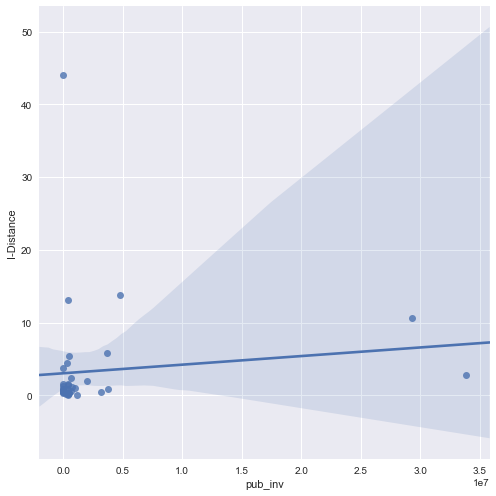

In [10]:
data_set = data_values[['city', 'pub_inv']].reindex(list(range(645))) #getting public investment 
scatter = distance1
scatterf = pd.merge(scatter, data_set, on='city') # creating the dataset with the paramter for the scatter plot


sns.lmplot('pub_inv', 'I-Distance', scatterf, size=7)

In spite of the fact that a good part of the cities don't have values for the feature, there is no evidence that, public investment alone contributes to better values for the index.

<h2>Making the I-Distance- not squared</h2>

In [11]:
def I_distance_norm(data_values, reference):
    
    # getting the correlation matrix done
    data_corr = data_values.drop('city' ,1).fillna(0)
    col_labels = list(data_corr.columns)
    corre = pd.DataFrame(partial_corr(data_corr), columns=col_labels)
                         
    #starting the I-Distance calculation                     
    ncolums = data_corr.shape[1]
    nrows = data_corr.shape[0]
    somatory = []
    i2_index = {'city': [], 'I-Distance': []}
    for r in range(0,nrows):
        somatory = []    
        for i in range(0,ncolums):
            prod = 1
            summ_1 = 0
            summ_1 = (np.absolute(data_corr.iloc[r,i] - reference.iloc[0,i+1]))/np.var(data_corr.iloc[:,i]) #distance squared divided by variance
            for k in range(i+1):
                if corre.iloc[i,k] == 1:
                    prod *= 1
                else:
                    prod *= (1-(corre.iloc[i,k]))
            somatory.append(summ_1*prod)
        i2_index['city'].append(data_values.iloc[r,0])
        i2_index['I-Distance'].append(np.cumsum(somatory)[-1])
    

## 5 - 6 selecting sigficant features

# calculating the rank of features and p-values

    distance = pd.DataFrame(i2_index)

    data = data_values.iloc[:,1:]
    feature_rank = {'feature': [], 'r': [], 'p-value': []}

    # creating the rank with correlation, p-values and name of features
    for col, values in data.iteritems():
        feature_rank['feature'].append(col)
        feature_rank['r'].append(stats.pearsonr(values, distance['I-Distance'])[0])
        feature_rank['p-value'].append(stats.pearsonr(values, distance['I-Distance'])[1])
    

    # manipulating the rank to select smallest correlation value with no significant p-value valor (>0.01)
    rank = pd.DataFrame(feature_rank)
    lenght_rank = len(list(rank.columns))
  
    excluded = {'feature' : "" , 'p-value' : 0 }
    for x in range(lenght_rank):
        excluded = {'feature' : "" , 'p-value' : 0 }
        chk = 0
        if rank.sort_values('r').iloc[x,1] >= 0.05 and x <= lenght_rank:  # check if the smallest r value is significant
            excluded['feature'] = rank.sort_values('r').iloc[x,0]
            excluded['p-value'] = rank.sort_values('r').iloc[x,1]
            chk = 1
            break
        elif rank.sort_values('r').iloc[x,1] <= 0.05 and x == lenght_rank:
            chk = 0
            break
        else:
            chk = 0
            continue

    if chk == 1: # returning new data frame if there is some variable to exclude, otherwise is done
        n_values = data_values.drop(excluded['feature'], 1)
        n_ref = reference.drop(excluded['feature'], 1)
        return 'loop',distance,  n_values, n_ref, excluded
    else:
        return 'done', distance, rank, 'ref', excluded # if no features to drop, return distance and rank

In [12]:
def Final_distance_norm(data_values, reference):
    check, distance, rank, ref, excluded = I_distance_norm(data_values, reference)
    
    cont=1
    while True:
        if check == 'loop':
            print("Iteration of Number: ", cont)
            print("Variable excluded in this iteration:", excluded )
            print("I-Distance rank:")
            print(distance)
            check, distance, rank, ref, excluded = I_distance_norm(rank, ref)
            cont += 1
            continue
        else:
            print("Iterations needed: ", cont-1)
            break
    return check, distance, rank

<h3> The Results for the I-Distance</h3>

In [13]:
check2, distance2, rank2 = Final_distance_norm(data_values, reference)

Iteration of Number:  1
Variable excluded in this iteration: {'feature': 'olding', 'p-value': 0.083299559371892526}
I-Distance rank:
     I-Distance                    city
0      0.814315              Adamantina
1      8.844093                  Adolfo
2      2.093593                   Aguaí
3      0.365900          Águas da Prata
4      5.227990        Águas de Lindóia
5      3.029922  Águas de Santa Bárbara
6      3.832458      Águas de São Pedro
7      3.681509                  Agudos
8      2.065421                Alambari
9      4.285084       Alfredo Marcondes
10     1.814622                  Altair
11     3.294260             Altinópolis
12     6.294743             Alto Alegre
13     5.500123                Alumínio
14     7.037874        Álvares Florence
15     1.606620         Álvares Machado
16     4.014925      Álvaro de Carvalho
17     1.212043             Alvinlândia
18     2.036627               Americana
19     3.910296     Américo Brasiliense
20     0.307014       Améri

In [14]:
rank2.sort_values("r", ascending=False)

,feature,p-value,r
1,gdp_growth,2.519221e-61,0.588352
0,gdp_per,1.639504e-08,0.220019
2,density_pop,3.476726e-02,-0.083140
3,urbing,7.199990e-05,-0.155650


As we can see, <b>using the normal form of the formula is not a good idea </b> once the variables are at most droped due to big differences in the discriminate effects.

# Working with clusters

<h4> Building the elbow method to choose optimized numbers of clusters

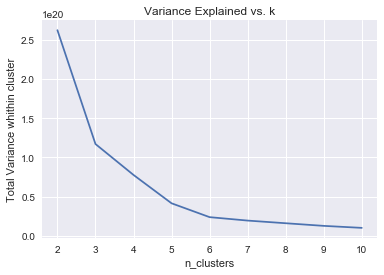

In [15]:
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist, pdist
from sklearn.decomposition import PCA

dataf = data_values.drop('city', 1)  # dropping the city column


# 2. Creating the matrix
x_cols = dataf.as_matrix(columns= list(dataf.columns))

# 3. Applying KMeans to the matrix
kmeans = KMeans().fit(x_cols)

# k values to test for
ktest = list(range(2,11)) 

# Fitting the Kmeans for the all the test values for different k`s
k_means_runs = [KMeans(n_clusters=k).fit(x_cols) for k in ktest]

# Taking the cluster centroids position
centroids = [cent.cluster_centers_ for cent in k_means_runs]


# Calculating the Euclidian distance from each cluster point to its correspondent centroid
k_dist = [cdist(x_cols, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis=1) for ke in k_dist]

# Distance within clusters
ss = [sum(d**2) for d in dist]


# Ploting
plt.plot(ktest, ss)
#plt.ylim((0,255))
plt.xlabel('n_clusters')
plt.ylabel('Total Variance whithin cluster')
plt.title('Variance Explained vs. k')

Using the Elbow Method, is clear to see that beginning from k =5 , the variance explained declines is a smaller rate, so our <b>optimal k for this case would be 5. 

<h4> Calculating the clusters

It looks like we have two data points, forming two different clusters, that are isolated. 

Label countdown:  {0: 629, 1: 1, 2: 11, 3: 1, 4: 3}


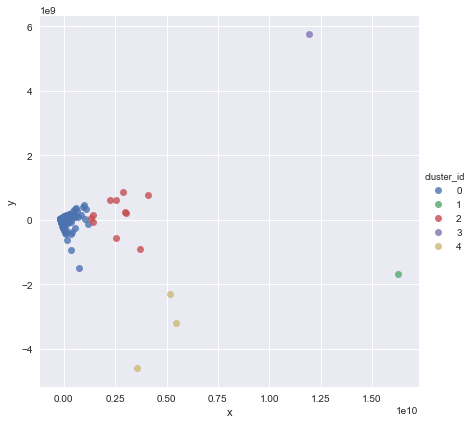

In [16]:
# getting the final model for the clusters with k=5

k_final = KMeans(n_clusters=5).fit(x_cols)

clabels = k_final.labels_

unique, counts = np.unique(clabels, return_counts=True)
label_count = {}
for x,y in zip(unique, counts):
    label_count[x] = y

print("Label countdown: ", label_count)


## Building some scatter plot to visualize the clusters

# getting the PCA components
pca = PCA(n_components=2)
x_cols_2 = pca.fit_transform(x_cols)

x, y = x_cols_2[:,0], x_cols_2[:,1]

# building the dataframe
l = list(range(1,33))
datac = pd.DataFrame()
datac['x'] = x
datac['y'] = y
datac['cluster_id'] = clabels
datac = datac.reset_index()

# ploting the scatter
sns.lmplot('x', 'y',  datac, hue='cluster_id' ,fit_reg=False, size=6)


Identifying the most representative cities for the cluster centroids:

In [17]:
min_dist = np.min(cdist(x_cols,k_final.cluster_centers_, 'euclidean'), axis=1) #calculating min distance between cities 
Y = pd.DataFrame(min_dist,index=dataf.index, columns=['distance'])              # and centroids
Z = pd.DataFrame(k_final.labels_,index=dataf.index, columns=['labels'])

YZ = pd.concat([Y,Z], axis=1)

grouped = YZ.groupby(['labels']) #grouping the distances by label so we can select the minimum one
grouped.idxmin()

,distance
labels,
0,7748
1,9601
2,10315
3,9669
4,9516


In [18]:
print("Representant of cluster 0 : ", data_values.loc[grouped.idxmin().distance[0]].city)
print("Representant of cluster 1 : ", data_values.loc[grouped.idxmin().distance[1]].city)
print("Representant of cluster 2 : ", data_values.loc[grouped.idxmin().distance[2]].city)
print("Representant of cluster 3 : ", data_values.loc[grouped.idxmin().distance[3]].city)
print("Representant of cluster 4 : ", data_values.loc[grouped.idxmin().distance[4]].city)


Representant of cluster 0 :  Porto Feliz
Representant of cluster 1 :  São Paulo
Representant of cluster 2 :  Taubaté
Representant of cluster 3 :  São Sebastião
Representant of cluster 4 :  São José dos Campos


<h4> Checking the I-Distance with the Cluster Labels

Inputing the cluster labels into the base

In [19]:
data_clust = data_values
data_clust['cluster'] = clabels  # including cluster labels to the dataset

col = list(data_clust.columns)
col = col[0:1] + col[-1:] + col[1:25]  # reordering the columns of the dataset to facilitate the function flow

data_clust = data_clust.reindex_axis(col, axis = 1) #reindexing the Dataframe

Getting the reference hyperplane

In [20]:
reference = data_clust.sort_values('gdp_per', ascending=True).iloc[0:1,:]

Changing the function to input the cluster labels to the rank

In [21]:
def I_distance(data_values, reference):
    # getting the correlation matrix done
    data_corr = data_values.drop(['city', 'cluster'] ,1).fillna(0)
    col_labels = list(data_corr.columns)
    corre = pd.DataFrame(partial_corr(data_corr), columns=col_labels)
                         
    #starting the I-Distance calculation                     
    ncolums = data_corr.shape[1]
    nrows = data_corr.shape[0]
    somatory = []
    i2_index = {'city': [], 'I-Distance': [], 'Cluster': []}
    for r in range(0,nrows):
        somatory = []    
        for i in range(0,ncolums):
            prod = 1
            summ_1 = 0
            summ_1 = ((data_corr.iloc[r,i] - reference.iloc[0,i+2])**2)/np.var(data_corr.iloc[:,i]) #distance squared divided by variance
            for k in range(i+1):
                if corre.iloc[i,k] == 1:
                    prod *= 1
                else:
                    prod *= (1-(corre.iloc[i,k])**2)
            somatory.append(summ_1*prod)
        i2_index['city'].append(data_values.iloc[r,0])
        i2_index['Cluster'].append(data_values.iloc[r,1]) ## ADDITION - adding the cluster label to the distance frame!!
        i2_index['I-Distance'].append(np.cumsum(somatory)[-1])
    

## 5 - 6 selecting sigficant features

# calculating the rank of features and p-values

    distance = pd.DataFrame(i2_index)

    data = data_values.iloc[:,1:]
    feature_rank = {'feature': [], 'r': [], 'p-value': []}

    # creating the rank with correlation, p-values and name of features
    for col, values in data.iteritems():
        feature_rank['feature'].append(col)
        feature_rank['r'].append(stats.pearsonr(values, distance['I-Distance'])[0])
        feature_rank['p-value'].append(stats.pearsonr(values, distance['I-Distance'])[1])
    

    # manipulating the rank to select smallest correlation value with no significant p-value valor (>0.01)
    rank = pd.DataFrame(feature_rank)
    lenght_rank = len(list(rank.columns))
  
    excluded = {'feature' : "" , 'p-value' : 0 }
    for x in range(lenght_rank):
        excluded = {'feature' : "" , 'p-value' : 0 }
        chk = 0
        if rank.sort_values('r').iloc[x,1] >= 0.05 and x <= lenght_rank:  # check if the smallest r value is significant
            excluded['feature'] = rank.sort_values('r').iloc[x,0]
            excluded['p-value'] = rank.sort_values('r').iloc[x,1]
            chk = 1
            break
        elif rank.sort_values('r').iloc[x,1] <= 0.05 and x == lenght_rank:
            chk = 0
            break
        else:
            chk = 0
            continue
    if chk == 1: # returning new data frame if there is some variable to exclude, otherwise is done
        n_values = data_values.drop(excluded['feature'], 1)
        n_ref = reference.drop(excluded['feature'], 1)
        return 'loop',distance,  n_values, n_ref, excluded
    else:
        return 'done', distance, rank, 'ref', excluded # if no features to drop, return distance and rank

In [22]:
def Final_distance(data_values, reference):
    check, distance, rank, ref, excluded = I_distance(data_values, reference)
    
    cont=1
    while True:
        if check == 'loop':
            print("Iteration of Number: ", cont)
            print("Variable excluded in this iteration:", excluded )
            print("I-Distance rank:")
            print(distance)
            check, distance, rank, ref, excluded = I_distance(rank, ref)
            cont += 1
            continue
        else:
            print("Iterations needed: ", cont-1)
            break
    return check, distance, rank

Getting the I-Distance squared rank with cluster labels:

In [23]:
checkc, distancec, rankc = Final_distance(data_clust, reference)

Iteration of Number:  1
Variable excluded in this iteration: {'feature': 'olding', 'p-value': 0.62152333001401172}
I-Distance rank:
     Cluster  I-Distance                    city
0          0   19.574375              Adamantina
1          0   12.623635                  Adolfo
2          0    7.619452                   Aguaí
3          0   14.912675          Águas da Prata
4          0   10.553639        Águas de Lindóia
5          0    4.973449  Águas de Santa Bárbara
6          0  175.278901      Águas de São Pedro
7          0   14.560906                  Agudos
8          0    2.860073                Alambari
9          0   13.647056       Alfredo Marcondes
10         0    7.707353                  Altair
11         0    9.946214             Altinópolis
12         0   16.617030             Alto Alegre
13         0   55.358300                Alumínio
14         0   20.329446        Álvares Florence
15         0    6.563823         Álvares Machado
16         0    1.786611      Álvar

In [24]:
distancec.sort_values('I-Distance', ascending=False)

,Cluster,I-Distance,city
564,1,5420.100823,São Paulo
568,3,253.370130,São Sebastião
559,4,150.584562,São José dos Campos
234,0,142.742285,Ilha Comprida
546,4,120.551111,São Bernardo do Campo
153,0,114.357130,Diadema
544,4,112.603475,Santos
310,0,112.293461,Louveira
590,0,104.851029,Taboão da Serra
64,2,102.321066,Barueri


In [25]:
rankc.sort_values('r', ascending=False)

,feature,p-value,r
5,violence,0.000000e+00,0.990580
12,jobs,0.000000e+00,0.989353
9,services_add,0.000000e+00,0.985795
7,value_add,0.000000e+00,0.982313
15,urban_pop,0.000000e+00,0.978691
14,population,0.000000e+00,0.978607
11,hosp_rooms,0.000000e+00,0.976214
17,fundamental,0.000000e+00,0.972127
2,pub_inv,0.000000e+00,0.951517
10,eletricity,8.198462e-314,0.944806


<h5>Looking for visual correlations for public investment and I-Distance  index

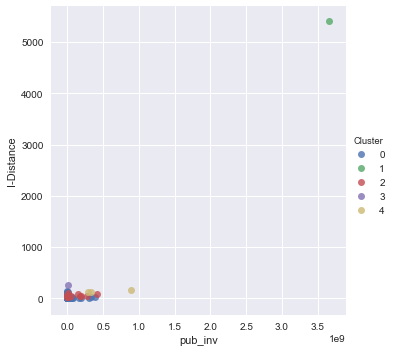

In [26]:
data_set = data_values[['city', 'pub_inv', 'gdp_per']] #getting public investment  and gdp per capita
scatter2 = distancec
scatterf2 = pd.merge(scatter2, data_set, on='city') # creating the dataset with the parameters for the scatter plot


sns.lmplot('pub_inv', 'I-Distance', scatterf2, hue='Cluster' , fit_reg=False)



There is no relationship when looking city by city

<h5>Trying separating with the clusters

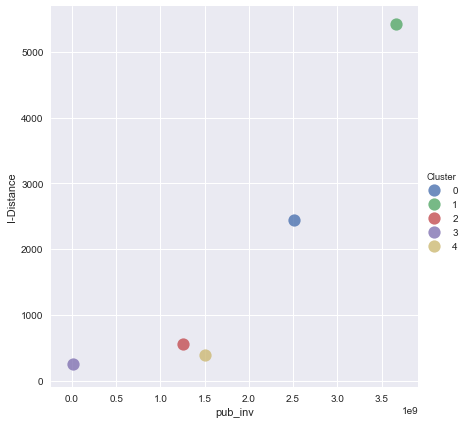

In [33]:
x = scatterf2.groupby('Cluster', as_index=False).sum()

sns.lmplot('pub_inv', 'I-Distance', x , hue='Cluster', fit_reg=False, size=6, scatter_kws={"s": 150})

Here we can see that there is a clear positive correlation between the I-Distance index and the public investment value, when looking to the <b> sum </b> of the values considering the cluster. <br> <br>

But we should try to use the median, because the cluster 0 has the big part of the cities, and this concetration could affect the picture. 

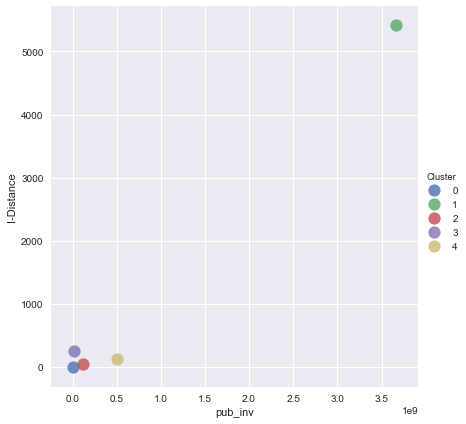

In [34]:
y = scatterf2.groupby('Cluster', as_index=False).mean()

sns.lmplot('pub_inv', 'I-Distance', y , hue='Cluster', fit_reg=False, size=6, scatter_kws={"s": 150})

Here we could se some interesting relationship between cluster that evidenciates that influence of public investment within this group of cities